<div align="right">Python 2.7 Jupyter Notebook</div>

# Network analysis using NetworkX

<div class="alert alert-warning">
<b>This notebook contains advanced exercises that are only applicable to students who wish to deepen their understanding and qualify for bonus marks on this course.</b> You will be able to achieve 100% for this notebook by successfully completing Exercises 1, 2, 3, 5, 6, and 7. An optional, additional exercise (Exercise 4) can be completed to qualify for bonus marks.
</div>

### Your completion of the notebook exercises will be graded based on your ability to do the following:

> **Understand**: Do your pseudo-code and comments show evidence that you recall and understand technical concepts?

> **Apply**: Are you able to execute code (using the supplied examples) that performs the required functionality on supplied or generated data sets? 

> **Analyze**: Are you able to pick the relevant method or library to resolve specific stated questions?

> **Evaluate**: Are you able to interpret the results and justify your interpretation based on the observed data?


#### Notebook objectives
By the end of this notebook, you will be expected to:
> 
  - Prepare a data set for graph analysis, using NetworkX;
  - Evaluate and compare structural properties of a graph object;
  - Interpret what information the structural properties provide in the physical world; and
  - Develop a basic understanding of small-world networks.
  
####  List of exercises:
> **Exercise 1**: Compute the number of call interactions between a pair of nodes.

>**Exercise 2**: Evaluate structure qualitatively in a graph based on visualization.

>**Exercise 3**: Create a graph object using the SMS data set.

>**Exercise 4 [Advanced]**: Compare the centrality structural properties evaluated on a graph.

>**Exercise 5**: Describe the effect on the average clustering coefficient when nodes of lower degree are removed.

>**Exercise 6**: List the two criteria of a small-world network.

>**Exercise 7**: Identify small-world networks, given the values for the characteristic path length and clustering coefficient.

# Notebook introduction 

<img src="img\social_network_analysis.png", width=350, height=350>

The use of phone logs to infer relationships between volume of communication and other parameters has been an area of major research interest. In his seminal paper,  which was the first application of phone logs, George Kingsley Zipf (1949) investigated the influence of distance on communication. Many studies have since followed. Big data is characterized by significant increases in structured and unstructured data generated by mobile phones that are sampled and captured at high velocities. Its emergence, and the availability of computer processing technologies that are able to store and process these data sets efficiently, has made it possible to expand these studies in order to improve our understanding of human behavior with unprecedented resolution. Mobile phone data allows the inference of real social networks using call detail records, or CDRs (i.e., phone calls, short message service (SMS) and multimedia message (MMS) communications). These records are combined with GPS and WiFi datasets, browsing habits, application logs, and tower data to reveal a superposition of several social actors.

According to Blondel et al. (2015):

> *The mobile nature of a mobile phone brings two advantages: first, the temporal patterns of communications [are] reflected in great detail due to the fact that the owner of the device usually carries the device with them and therefore the possibility of receiving the call exists in almost all cases, and second, the positioning data of a mobile phone allows tracking the displacements of its owner*.

Unlike self-reported surveys – which are often subjective, limited to a very small subset of the population, and have been the only avenue used to gather data in the past – mobile phone CDRs contain information on verifiable communications between millions of people at a time. Further enrichment from geolocation data, which invariably is also collected alongside CDRs, as well as other external data that is available for the target segment (typically demographics), makes mobile phone CDRs an extremely rich and informative source of data for scientists and analysts. 

These interactions via mobile phones can be represented by a large network where nodes represent individuals, and links are drawn between individuals that have had a phone call, or exchanged messages or other media. 

The study of the structure of such networks provides useful insights into their organization, and can assist in improving communication infrastructure, understanding human behavior, traffic planning, and marketing initiatives, among others. According to Gautier Krings (2012), these applications are informed by the extraction and analysis of different kinds of information from large networks, including the following:

1. **Associating every node with geographical coordinates.** This can facilitate how geography influences the creation of links. More specifically, the intensity of communication between nodes decreases as a power of the geographical distance that separates them.

2. **Studying how links in networks change over time (i.e., dynamical networks).** In these networks, new nodes enter or leave the network and the strength of their connections rise and wane during the observation period. Of particular interest is the influence of time scales on the emergence of different structural properties of dynamical networks.

3. **Detecting communities in networks.** Communities are groups of nodes that are densely connected to each other. 



**Load libraries and set global parameters for Matplotlib**

In [1]:
# Load the relevant libraries to your notebook. 
import csv                     # Process csv files.
import pandas as pd            # Processing csv files and manipulating the DataFrame.
import networkx as nx          # Graph-like object representation and manipulation module.
import matplotlib.pylab as plt # Plotting and data visualization module. 
                               # We use this for basic graph visualization.
import numpy as np       

from networkx.drawing.nx_agraph import graphviz_layout

import random

from IPython.display import Image, display

# Set global parameters for plotting. 
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

In [5]:
def pydot(G):
    pdot = nx.drawing.nx_pydot.to_pydot(G)
    display(Image(pdot.create_png()))

# 1. Graph structures using NetworkX
In this notebook, you will continue working with the empirical dataset from the "Friends and Family" study used in Module 2. 

### 1.1 Data preparation

As before, the first step is preparing the data for analysis. In the following, you will load the data into a DataFrame object, filter and retain the records of interest, and select the fields or data columns to use when creating graph objects.

#### 1.1.1 Load the data into a DataFrame
In this data, each record or row is typical of what is available in a CDR, i.e., the actors involved, the starting time of the interaction, the duration of the interaction, who initiated it, and who was the recipient, among other details not included here (such as the geolocation of the sender and receiver). 

In [6]:
# Read the CallLog.csv file, print the number of records loaded as well as the first 5 rows.
calls = pd.read_csv('../data/CallLog.csv')
print 'Loaded {0} rows of call log.'.format(len(calls))
calls.head()

Loaded 164905 rows of call log.


participantID.A participantID.B           local_time       type  duration  \
0      sp10-01-02             NaN  2010-08-04 19:11:51  outgoing+       NaN   
1      sp10-01-02             NaN  2010-08-04 18:49:26  outgoing+       NaN   
2      sp10-01-53      sp10-01-04  2010-07-10 19:24:25  outgoing+       NaN   
3      sp10-01-53      sp10-01-04  2010-07-10 19:24:17  outgoing+       NaN   
4      sp10-01-53             NaN  2010-07-15 18:04:23  incoming+       NaN   

                                number.hash  
0   da83375fb3a7631f304a9471add44eeb19d3355  
1   da83375fb3a7631f304a9471add44eeb19d3355  
2  e729a096a6c30c9f523e56329b4cdc7993d83b00  
3  e729a096a6c30c9f523e56329b4cdc7993d83b00  
4  ec5be5bbb1a719fc8c348ebbc577b99a61457575

#### 1.1.2 Row filtering

In the data set, there are calls to outsiders that can be seen in each entry where the participant's ID is "`NaN`". These are not relevant to the current exercise and need to be removed before you proceed. Remove all calls where one of the participant IDs is missing. First, check the number of records in your DataFrame using Pandas's [shape  DataFrame method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html).

In [7]:
# Initial number of records.
calls.shape[0]

164905

Next, review the data using the ``info()`` method.

In [8]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164905 entries, 0 to 164904
Data columns (total 6 columns):
participantID.A    164905 non-null object
participantID.B    60518 non-null object
local_time         164905 non-null object
type               164904 non-null object
duration           59124 non-null float64
number.hash        164905 non-null object
dtypes: float64(1), object(5)
memory usage: 7.5+ MB


Next, you will clean the data by removing interactions involving outsiders as discussed above. Removing missing values is very common in data analysis, and Pandas has a convenient method, appropriately named [dropna()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html), designed to automate this cleaning process.

In [9]:
# Drop rows with NaN in either of the participant ID columns.
calls = calls.dropna(subset = ['participantID.A', 'participantID.B'])
print('{} rows remaining after dropping missing values from selected columns.'.format(len(calls)))
calls.head(n=5)

60518 rows remaining after dropping missing values from selected columns.


participantID.A participantID.B           local_time       type  duration  \
2       sp10-01-53      sp10-01-04  2010-07-10 19:24:25  outgoing+       NaN   
3       sp10-01-53      sp10-01-04  2010-07-10 19:24:17  outgoing+       NaN   
6       sp10-01-53      sp10-01-52  2010-07-20 19:25:54  outgoing+       NaN   
26      sp10-01-01      sp10-01-53  2010-07-23 19:06:01  outgoing+       NaN   
29      sp10-01-01      sp10-01-02  2010-07-23 18:51:17  incoming+       NaN   

                                 number.hash  
2   e729a096a6c30c9f523e56329b4cdc7993d83b00  
3   e729a096a6c30c9f523e56329b4cdc7993d83b00  
6   e22a3263eb0280fa601c400bc87e178a9ac5d3f7  
26  627e38ee55f5373a9bb5133558d623d7b8fe8ff6  
29  6db007cb74cc8537b99e7d230c0452f4ba71d13e

#### 1.1.3 Column selection

For the purpose of this study, you should only focus on the social actors involved in the call interaction. Therefore, you can remove all columns not relevant to the network being analyzed.

In [10]:
# Create a new object containing only the columns of interest.
interactions = calls[['participantID.A', 'participantID.B']]

Finally, exclude rows where the actors are the same.

In [11]:
# Get a list of rows with different participants.
row_with_different_participants = interactions['participantID.A'] != interactions['participantID.B']

# Update "interactions" to contain only the rows identified. 
interactions = interactions.loc[row_with_different_participants,:]
interactions.head()

participantID.A participantID.B
2       sp10-01-53      sp10-01-04
3       sp10-01-53      sp10-01-04
6       sp10-01-53      sp10-01-52
26      sp10-01-01      sp10-01-53
29      sp10-01-01      sp10-01-02

In [12]:
len(interactions)

57625

### 1.2 Creating graph objects with NetworkX
The call interactions captured above are directed, meaning that edges (u,v) and (v,u) are different.

First, let's try to capture the number of interactions between social actors, irrespective of who initiated the call. This will be done using an undirected graph. You will need to capture the number of interactions between any pair of actors with a link in the graph. Therefore, the graph object that needs to be created is a weighted undirected graph.

Using a Pandas DataFrame object as direct input into NetworkX to create graphs,  the following demonstration illustrates how to build an unweighted and undirected graph.

In [13]:
# Create an unweighted undirected graph using the NetworkX's from_pandas_dataframe method.
# The column participantID.A is used as the source and participantID.B as the target.
G = nx.from_pandas_dataframe(interactions, 
                             source='participantID.A', 
                             target='participantID.B', 
                             create_using=nx.Graph())

Review basic information on your graph.

In [14]:
# Print the number of nodes in our network.
print 'The undirected graph object G has {0} nodes.'.format(G.number_of_nodes())

# Print the number of edges in our network.
print 'The undirected graph object G has {0} edges.'.format(G.number_of_edges())

The undirected graph object G has 129 nodes.
The undirected graph object G has 392 edges.


In the following cells, the neighbors for five of the nodes are saved in Python dict, with the node label as key, and then printed.

In [15]:
# Declare a variable for number of nodes to get neighbors of.
max_nodes = 5

In [16]:
# Variable initialization.
count = 0
ndict = {}

# Loop through G and get a node's neigbours, store in ndict, up to 5 nodes. 
for node in list(G.nodes()):
    ndict[node] = tuple(G.neighbors(node))
    count = count + 1
    if count > max_nodes:
        break

In [17]:
print(ndict)

{'fa10-01-78': ('fa10-01-77', 'fa10-01-62'), 'fa10-01-79': ('fa10-01-21', 'fa10-01-80', 'sp10-01-23', 'fa10-01-22'), 'sp10-01-52': ('fa10-01-82', 'fa10-01-81', 'fa10-01-44', 'sp10-01-01', 'sp10-01-02', 'sp10-01-53', 'sp10-01-43', 'fa10-01-72', 'fa10-01-04', 'sp10-01-26', 'fa10-01-43', 'fa10-01-71', 'sp10-01-33'), 'sp10-01-53': ('sp10-01-04', 'fa10-01-81', 'fa10-01-44', 'sp10-01-01', 'fa10-01-82', 'sp10-01-52', 'sp10-01-55', 'fa10-01-71', 'fa10-01-04'), 'fa10-01-74': ('sp10-01-49', 'fa10-01-83', 'fa10-01-80', 'sp10-01-41', 'sp10-01-40', 'sp10-01-42', 'sp10-01-45', 'fa10-01-73', 'sp10-01-46', 'fa10-01-14', 'sp10-01-39', 'fa10-01-04', 'sp10-01-23', 'sp10-01-35'), 'fa10-01-75': ('fa10-01-76', 'fa10-01-10', 'fa10-01-13')}


In [18]:
# Print only the first item in the dict.
print([ndict.keys()[0], ndict[ndict.keys()[0]]])

['fa10-01-78', ('fa10-01-77', 'fa10-01-62')]


Your original objective is to create a **weighted undirected** graph for call interactions, with the weights representing the number of interactions between two distinct participants. As illustrated above, you can use the "from_pandas_dataframe" method to build an undirected graph between the pairs of actors, by specifying the graph structure using a parameter to the argument "create_using=". To get the correct weights in the undirected graph, however, you will need to add the weight information separately. Unfortunately, you cannot rely on NetworkX to do this as it cannot be used to control what data the undirected edges get. Below is a description of how to add the necessary weights to the undirected graph.

The first task is to compute the number of interactions between participants. You will use Pandas' "group_by" DataFrame method to achieve this.

In [19]:
# Get the count of interactions between participants and display the top 5 rows.
grp_interactions = pd.DataFrame(interactions.groupby(['participantID.A', 'participantID.B']).size(), 
                                columns=['counts']).reset_index()

grp_interactions.head(5)

participantID.A participantID.B  counts
0      fa10-01-01      fa10-01-02     870
1      fa10-01-01      fa10-01-05       1
2      fa10-01-01      fa10-01-17       3
3      fa10-01-02      fa10-01-01    1254
4      fa10-01-02      fa10-01-18       2

In [20]:
# Create a directed graph with an edge_attribute labeled counts.
g = nx.from_pandas_dataframe(grp_interactions, 
                             source='participantID.A', 
                             target='participantID.B', 
                             edge_attr='counts', 
                             create_using=nx.DiGraph())

Instantiate a weighted undirected graph, and populate edge information using the edges list from the directed graph.

In [21]:
# Set all the weights to 0 at this stage. We will add the correct weight information in the next step.
G = nx.Graph()
G.add_edges_from(g.edges(), counts=0)

Now, iterate through each link from the directed graph, adding the attribute weight (counts) to the corresponding link in the undirected graph.

In [22]:
for u, v, d in g.edges(data=True):
    G[u][v]['counts'] += d['counts']

Look at some of the edges and their corresponding weights.

In [23]:
# Print the first 5 edges with corresponding attribute data.
max_number_of_edges = 5
count = 0
for n1,n2,attr in G.edges(data=True): # unpacking
    print n1,n2,attr
    count = count + 1
    if count > max_number_of_edges:
        break     

fa10-01-78 fa10-01-77 {'counts': 328}
fa10-01-78 fa10-01-62 {'counts': 1}
fa10-01-79 fa10-01-21 {'counts': 50}
fa10-01-79 fa10-01-80 {'counts': 351}
fa10-01-79 fa10-01-22 {'counts': 60}
fa10-01-79 sp10-01-23 {'counts': 1197}


You can verify whether the steps you executed above have worked using the following:

In [24]:
# Verify our attribute data is correct using a selected (u,v) pair from the data.
u = 'fa10-01-77'
v = 'fa10-01-78'
print 'Number of undirected call interactions between {0} and {1} is {2}.'.format(u,
                                                                                 v,
                                                                                 G.get_edge_data(v,u)['counts'])

Number of undirected call interactions between fa10-01-77 and fa10-01-78 is 328.


In [25]:
# Compare our data set to the interactions data set.
is_uv_pair = ((interactions['participantID.A'] == u) & (interactions['participantID.B'] == v)) 
is_vu_pair = ((interactions['participantID.A'] == v) & (interactions['participantID.B'] == u))
print 'Number of undirected call interactions between {0} and {1} is {2}'.format(u,
                                                                      v, 
                                                                      interactions[is_uv_pair | is_vu_pair].shape[0])

Number of undirected call interactions between fa10-01-77 and fa10-01-78 is 328


Based on the comparison above, it can be said with confidence that your graph object captures the interactions as expected.

<br>
<div class="alert alert-info">
<b>Exercise 1 Start.</b>
</div>

### Instructions
> Calculate the number of call interactions between participant sp10-01-52 and participant fa10-01-81 captured in your graph, using any of the above approaches.


In [29]:
# Your answer here.
# I'll follow the example approach by calling out the 2 participants as my u and v values
u = 'sp10-01-52'
v = 'fa10-01-81'

In [30]:
# the number of intereations is simply the number of edges between u and v
print 'Number of call interactions between participant {0} and participant {1} is {2}.'.format(u,v,
                                                                                 G.get_edge_data(v,u)['counts'])

Number of call interactions between participant sp10-01-52 and participant fa10-01-81 is 31.


In [31]:
# And for argument sake, I might as well validate the second method in the example approach..
is_uv_pair = ((interactions['participantID.A'] == u) & (interactions['participantID.B'] == v)) 
is_vu_pair = ((interactions['participantID.A'] == v) & (interactions['participantID.B'] == u))
print 'Number of call interactions between participant {0} and participant {1} is {2}.'.format(u,v, 
                                                                      interactions[is_uv_pair | is_vu_pair].shape[0])

Number of call interactions between participant sp10-01-52 and participant fa10-01-81 is 31.


<br>
<div class="alert alert-info">
<b>Exercise 1 End.</b>
</div>

> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

### 1.3 Graph visualization
The next step is to visualize the graph object – a topic that you briefly touched on in Notebook 1. NetworkX is not primarily a graph drawing package, but provides basic drawing capabilities using Matplotlib. More advanced graph visualization packages can be used. However, these are outside of the scope of this course.

[NetworkX documentation](https://networkx.github.io/documentation/networkx-1.10/reference/drawing.html) (2015) states:
> Proper graph visualization is hard, and we highly recommend that people visualize their graphs with tools dedicated to that task. Notable examples of dedicated and fully-featured graph visualization tools are Cytoscape, Gephi, Graphviz and, for LaTeX typesetting, PGF/TikZ.

A graph is an abstract mathematical object without a specific representation in the Cartesian coordinate space, and graph visualization is therefore not a well-defined problem with a unique solution. Depending on which structures in the graph object are of interest, several layout algorithms exist that can be used to optimize node positioning for display visualization. Whenever you want to visualize a graph, you have to find mapping from vertices to Cartesian coordinates first, preferably in a way that is aesthetically pleasing. A separate branch of graph theory, namely graph drawing, attempts to solve this problem via several graph layout algorithms.

You will use the interface provided by [Graphviz](http://graphviz.org/Home.php) for node positioning in most of your visualization in this course, because considering other possibilities may distract from the core objectives. Two node positioning algorithms can be accessed using the Graphviz interface provided by NetworkX. They are the following:
-  **dot**: "hierarchical" or layered drawings of directed graphs. This is the default to use if edges have directionality. The dot algorithm produces a ranked layout of a graph honoring edge directions. It is particularly appropriate for displaying hierarchies or directed acyclic graphs.
- **neato**: "spring model" layouts.  This is the default to use if the graph is not too large (about 100 nodes), and you don't know anything else about it. Neato attempts to minimize a global energy function, which is equivalent to statistical multidimensional scaling. An ideal spring is placed between every pair of nodes, such that its length is set to the shortest path distance between the endpoints. The springs push the nodes so their geometric distance in the layout approximates their path distance in the graph.

Below is a visual display of your weighted undirected call graph, using different visualization approaches.

#### 1.3.1 Graphviz layout using the "dot" engine

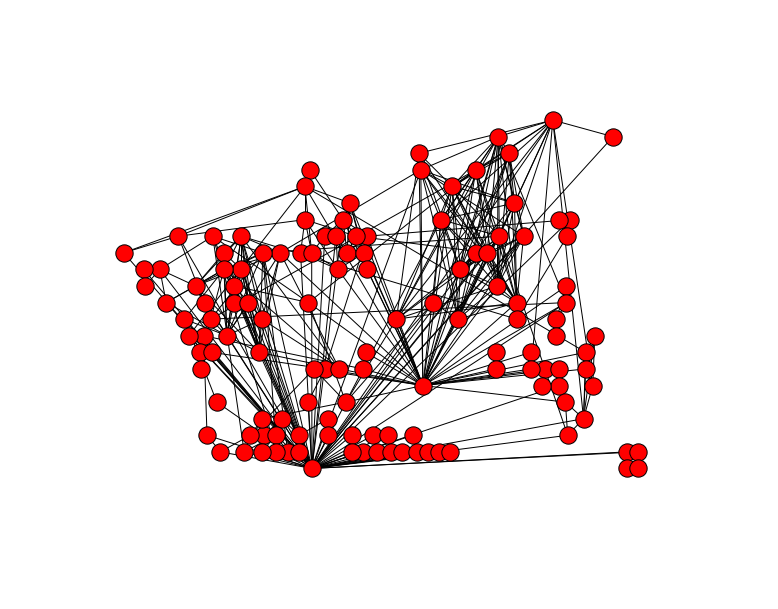

In [32]:
pos = graphviz_layout(G, prog='dot') # you can also try using the "neato" engine
nx.draw(G,pos=pos)

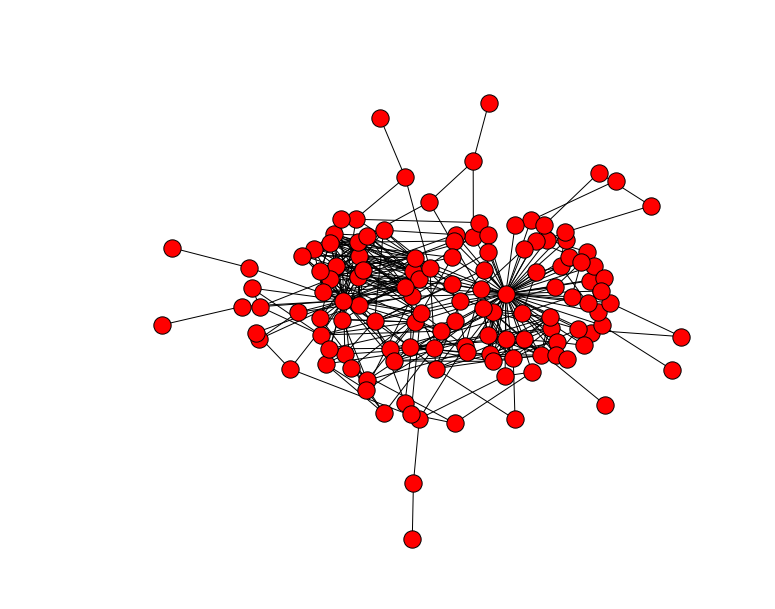

In [33]:
pos = graphviz_layout(G, prog='neato') # changed "dot" to "neato" engine
nx.draw(G,pos=pos)

#### 1.3.2 Graph visualization using NetworlX's in-built "Spring layout"

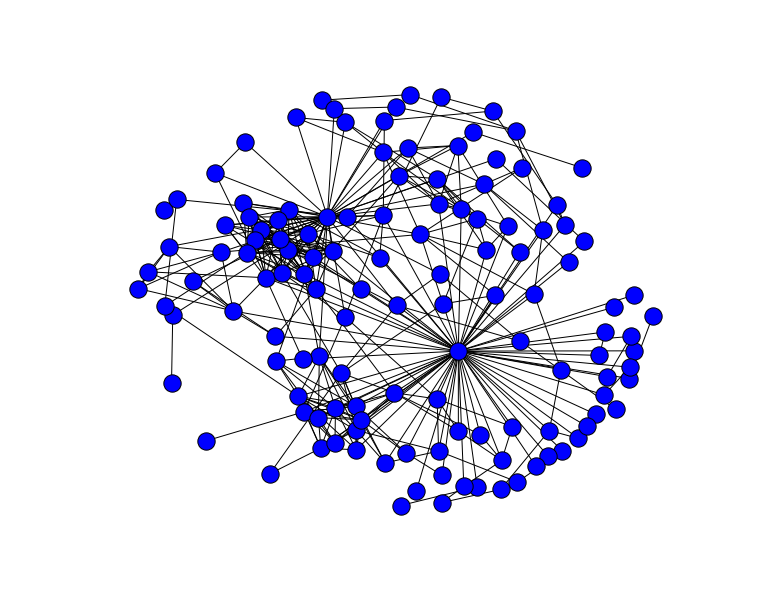

In [34]:
layout = nx.spring_layout(G)
nx.draw(G, pos=layout, node_color='blue')

#### 1.3.3 Graph visualization with Pydot rendering

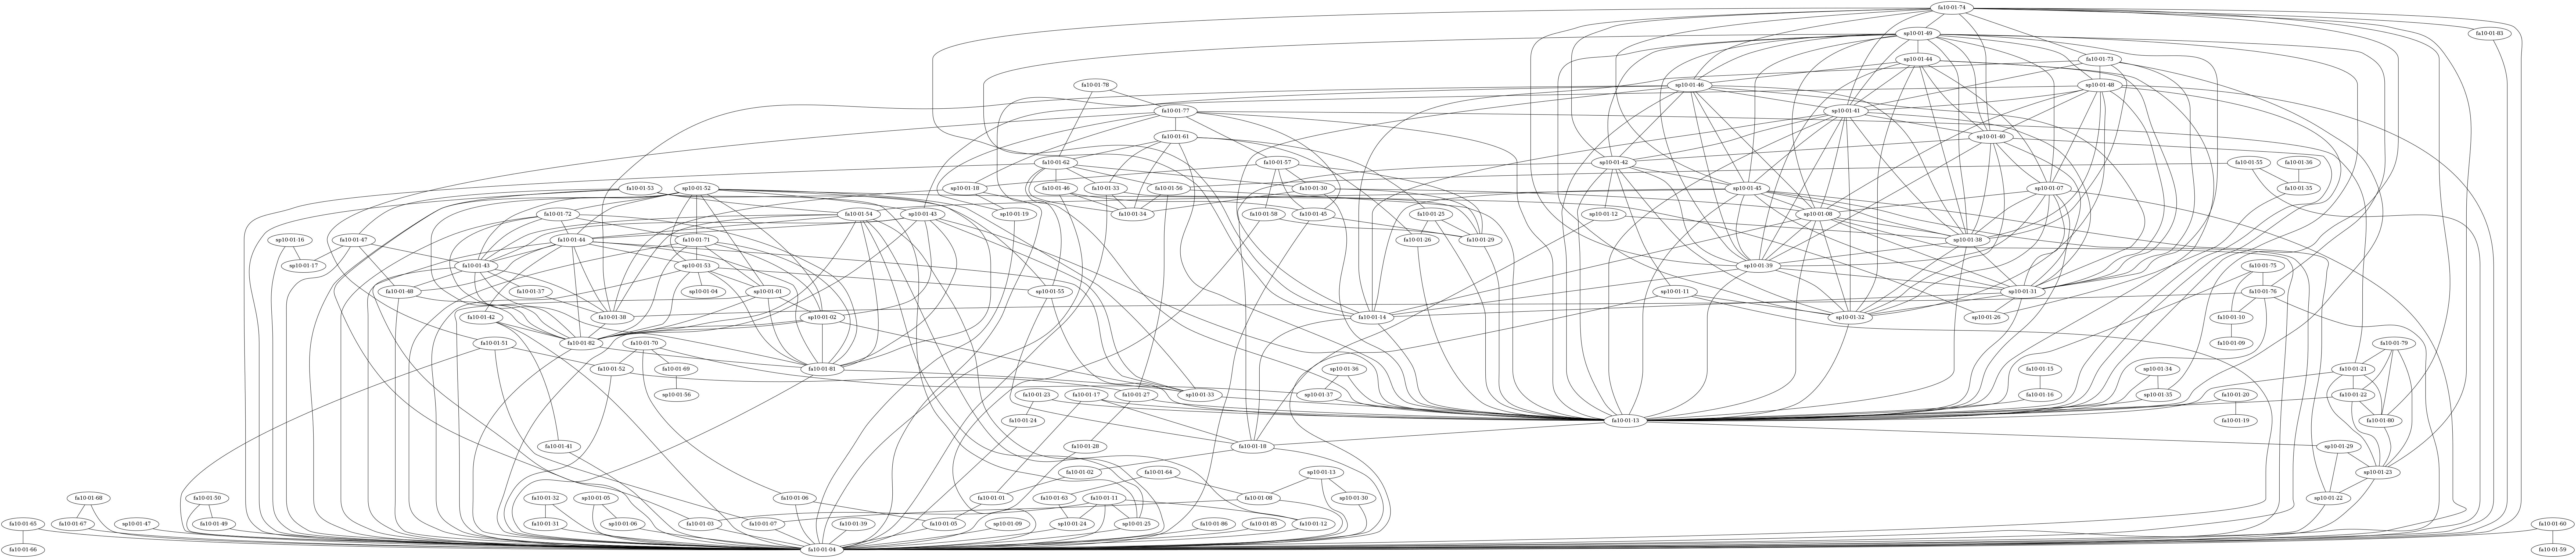

In [35]:
pydot(G)

<br>
<div class="alert alert-info">
<b>Exercise 2 Start.</b>
</div>

### Instructions 

> Based on the various visualizations explored above, what can you tell about these networks and the types of interactions they capture? Please provide written feedback (a sentence or two) based on your insights of the call log data in the markdown cell below.

> **Hint**:
- In your answer, indicate if there appears to be some structure in the graph, or if the connections between nodes appear random (i.e., do some nodes have more links than others)? Do the participants cluster into identifiable communities or not?

Your markdown answer here.

#### These are my observations:
>* I can now understand the usefulness of the Graphviz package; the pydot (NetworkX) plot could only show a convoluted maze if I want to visualise a large number of vertices
>* Since the documentation says that the dot method is suitable for hierachical and directed graphs, it may not be the best tool for our call data (which is non-directional). However, in spite of this, the dot method still show patterns of community in the layout, with a few vertices with high degrees of centrality. 
>* The neato method is neat. It shows some clear polarisation into at least 2 clusters - the one on the right around a vertex with very high eigenvector, and on the left several vertices with high betweenness centrality. This neato visualisation also alluded to our call data resembling a small world network - short avg paths, high cluster coefficients.
>* The spring layout extension of neato is cool. By visualisation, I can almost do a graph partitioning based on k=2 clusters, instead of testing out with community detection.

<br>
<div class="alert alert-info">
<b>Exercise 2 End.</b>
</div>

> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

<br>
<div class="alert alert-info">
<b>Exercise 3 Start.</b>
</div>

### Instructions

You will now need to reproduce the steps above for SMS records.

> 1. Load the file "SMSLog.csv" from the data folder in your home directory, into a variable "sms".
> 2. Create a weighted undirected graph using the number of interactions between participants as weights.
> 3. Assign the graph to variable "H" (do not overwrite "G" as you will still use it below).
> 4. Ignore all interactions where one of the parties is missing or unknown (i.e. "`NaN`").
> 5. Disregard any self-interactions.
> 6. Display a visualization of the obtained graph network, using the spring_layout algorithm for node positioning.


>**Hints**:
>
> - Make sure that you use different variables when loading the datasets, and remember that you can always insert additional cells in the notebook, should you prefer to break up steps or perform additional investigations.

> - It is good practice to make clear comments (start the line with #) in your code when sharing your work or if you need to review it at a later stage. Make sure that you add comments to enable your tutor to understand your thinking process.

> - The number of cells below are only indicative. You can insert additional cells as required.




In [36]:
# Your answer here.

#### 1. Load the file "SMSLog.csv" from the data folder in your home directory, into a variable "sms".

In [37]:
# Read the CallLog.csv file, print the number of records loaded as well as the first 5 rows.
sms = pd.read_csv('../data/SMSLog.csv')
print 'Loaded {0} rows of call log.'.format(len(sms))
sms.head()

Loaded 88655 rows of call log.


participantID.A participantID.B           local_time      type  \
0      sp10-01-53             NaN  2010-07-14 14:56:29  incoming   
1      sp10-01-53             NaN  2010-07-14 14:56:26  incoming   
2      sp10-01-53             NaN  2010-07-14 14:56:13  incoming   
3      sp10-01-53             NaN  2010-07-14 20:16:31  incoming   
4      sp10-01-53             NaN  2010-07-14 19:47:07  incoming   

                                number.hash  
0  d4498bd944a37e11428dc0df1eec7ec24ab222aa  
1  e8b7eebeee26055a9511393154eb44e16184b367  
2  d4498bd944a37e11428dc0df1eec7ec24ab222aa  
3  6f43e2b8771ff9468611900fef42d4497e26ffa2  
4  6f43e2b8771ff9468611900fef42d4497e26ffa2

In [38]:
# Learning more about the sms data
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88655 entries, 0 to 88654
Data columns (total 5 columns):
participantID.A    88655 non-null object
participantID.B    33757 non-null object
local_time         88655 non-null object
type               88655 non-null object
number.hash        88655 non-null object
dtypes: object(5)
memory usage: 3.4+ MB


>1a. Data Cleansing should be done early, so I am going to drop NaN vertices here and save cpu cycles as well..

In [39]:
# Drop rows with NaN in either of the participant ID columns.
sms = sms.dropna(subset = ['participantID.A', 'participantID.B'])
print('{} rows remaining after dropping missing values from selected columns.'.format(len(sms)))
sms.head(n=5)

33757 rows remaining after dropping missing values from selected columns.


participantID.A participantID.B           local_time      type  \
74      sp10-01-07      sp10-01-08  2010-07-23 10:03:01  incoming   
88      sp10-01-08      sp10-01-07  2010-07-23 10:02:55  outgoing   
89      sp10-01-48      sp10-01-49  2010-07-23 13:59:20  incoming   
90      sp10-01-48      sp10-01-49  2010-07-23 13:59:15  incoming   
91      sp10-01-48      sp10-01-49  2010-07-23 13:48:03  incoming   

                                 number.hash  
74  c414c72362fdd424b77c917738a7798fe0d42906  
88  3ba7c43d1ce921f787e6205627e16159ee426be3  
89  8f8d7ef27f9062590657cf9d41cad9ae9eeb0049  
90  8f8d7ef27f9062590657cf9d41cad9ae9eeb0049  
91  8f8d7ef27f9062590657cf9d41cad9ae9eeb0049

#### 2. Create a weighted undirected graph using the number of interactions between participants as weights.

>2a. Before creating the graphs, I am also going to wrangle to data further by removing self interactions as an early step, rather then going thru the cost of creating a huge graph, and then do something like a graph.remove()

In [40]:
# Create a new object containing only the columns of interest.
interactions = sms[['participantID.A', 'participantID.B']]

# Get a list of rows with different participants.
row_with_different_participants = interactions['participantID.A'] != interactions['participantID.B']

# Update "interactions" to contain only the rows identified. 
interactions = interactions.loc[row_with_different_participants,:]
interactions.head()

participantID.A participantID.B
74      sp10-01-07      sp10-01-08
88      sp10-01-08      sp10-01-07
89      sp10-01-48      sp10-01-49
90      sp10-01-48      sp10-01-49
91      sp10-01-48      sp10-01-49

In [41]:
# Create an unweighted undirected graph (GS) using the NetworkX's from_pandas_dataframe method.
# The column participantID.A is used as the source and participantID.B as the target.
GS = nx.from_pandas_dataframe(interactions, 
                             source='participantID.A', 
                             target='participantID.B', 
                             create_using=nx.Graph())

In [42]:
# Print the number of nodes in the sms network.
print 'The undirected graph object GS has {0} nodes.'.format(GS.number_of_nodes())

# Print the number of edges in the sms network.
print 'The undirected graph object GS has {0} edges.'.format(GS.number_of_edges())

The undirected graph object GS has 84 nodes.
The undirected graph object GS has 135 edges.


In [43]:
# Get the count of interactions between participants and display the top 5 rows.
grp_interactions = pd.DataFrame(interactions.groupby(['participantID.A', 'participantID.B']).size(), 
                                columns=['counts']).reset_index()

grp_interactions.head(5)

participantID.A participantID.B  counts
0      fa10-01-01      fa10-01-02    1462
1      fa10-01-01      fa10-01-05       3
2      fa10-01-01      fa10-01-07       1
3      fa10-01-02      fa10-01-01    1338
4      fa10-01-05      fa10-01-01       3

In [44]:
# Create a directed graph (gs) with an edge_attribute labeled counts.
gs = nx.from_pandas_dataframe(grp_interactions, 
                             source='participantID.A', 
                             target='participantID.B', 
                             edge_attr='counts', 
                             create_using=nx.DiGraph())

In [45]:
# Set all the weights to 0 at this stage. 
GS = nx.Graph()
GS.add_edges_from(gs.edges(), counts=0)

In [46]:
# Add the correct weight information in this next step.
for u, v, d in gs.edges(data=True):
    GS[u][v]['counts'] += d['counts']

In [47]:
# Verify our attribute data is correct using a selected (u,v) pair from the data.
# The graph is undirected, so the number of edges (counts) should be the sum of both u-v directions
u = 'fa10-01-01'
v = 'fa10-01-05'
print 'Number of undirected sms interactions between {0} and {1} is {2}.'.format(u,
                                                                                 v,
                                                                                 GS.get_edge_data(v,u)['counts'])

Number of undirected sms interactions between fa10-01-01 and fa10-01-05 is 6.


#### 3. Assign the graph to variable "H" (do not overwrite "G" as you will still use it below).

In [48]:
# Assign G to new graph H
H = GS

#### 4. Ignore all interactions where one of the parties is missing or unknown (i.e. "NaN").

>* Not sure why this data cleasing step is here; I have already removed NaN in step 1a above

#### 5. Disregard any self-interactions.

>* Again I am not sure why this data wrangling step shoul be here; I've already removed self-interactions in step2a

#### 6. Display a visualization of the obtained graph network, using the spring_layout algorithm for node positioning.

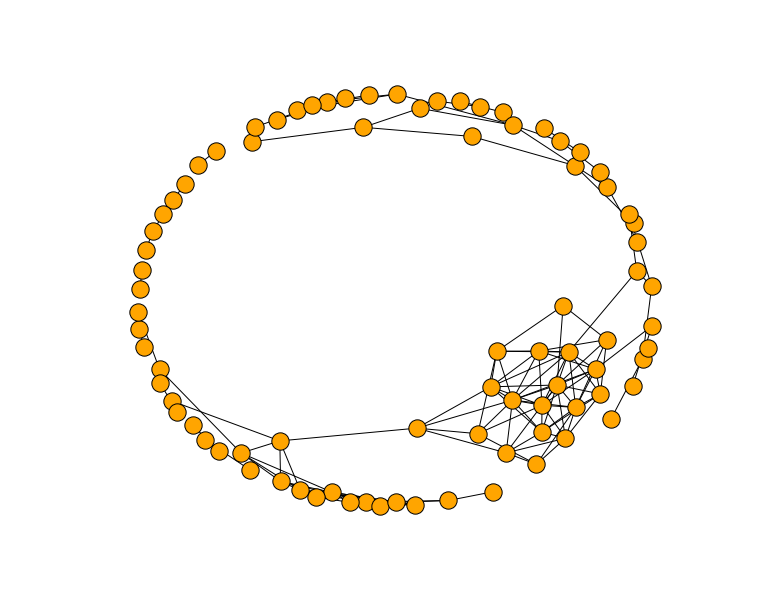

In [49]:
# Ploting on graph object H...
layout = nx.spring_layout(H)
nx.draw(H, pos=layout, node_color='orange')

#### Observations:

>* Hmm.. interesting. sms pattern looks quite different from call patterns. Nearly all the vertices are at the edge (low vertex degree). 
>* This is a long-tail degree distribution. It's almost like sms messaging is used very infrequently by the Friends and Family residential living community. 
>* All members of the community are couples, this probably provided the 'ground truth' that couples mostly sms only to each other. 
>* Rarely, does one node sms to to multiple parties.

<br>
<div class="alert alert-info">
<b>Exercise 3 End.</b>
</div>

> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

## 2. Computing and visualizing structural properties of networks
Physical networks exhibit different behaviors. Since graph objects are abstractions of these behaviors, you might expect these graphs to be different. To characterize these differences, you need more than visualizations that are pleasing to the eye. To this end, a number of characteristics have been developed to characterize the structural properties of graphs. These properties help you understand and characterize physical networks with more mathematical rigor. You will now explore characteristics discussed in the video content.

### 2.1 Degree distribution
The degree of a node in a network is the number of connections it has to other nodes, and the degree distribution (also referred to as the neighbor distribution) is the probability distribution of these degrees over the whole network. Specifically, the degree distribution $p(k)$ is the probability that a randomly-chosen node has $k$ connections (or neighbors).

#### 2.1.1 Degree distribution histogram
A degree distribution histogram is a plot of the frequency of occurrence of the number of connections or neighbors, based on the relationships (edges) between entities (nodes), as represented by a graph object.

Continuing with the call data (graph G), from the preceding sections, you will now compute and plot the degree distribution of the data.

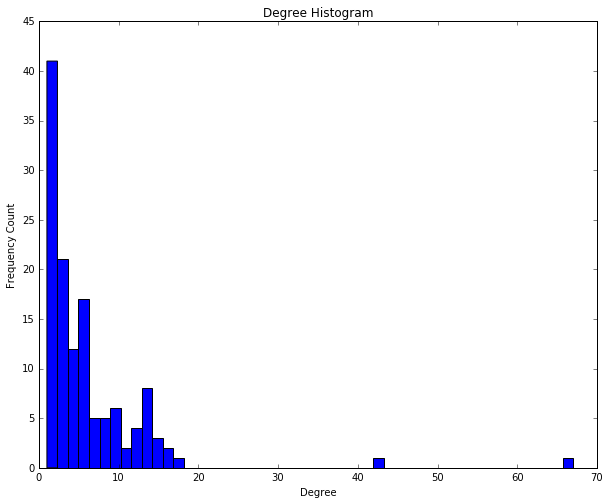

In [50]:
# Plot the degree distribution histogram.
degrees  = G.degree() # output is a dict node:degree
out = plt.hist(degrees.values(), bins=50)
plt.title("Degree Histogram")
plt.ylabel("Frequency Count")
plt.xlabel("Degree")

#### 2.1.2 Logarithmic plot of the degree distribution

In many cases, the histogram distribution is best represented using a log-log plot.

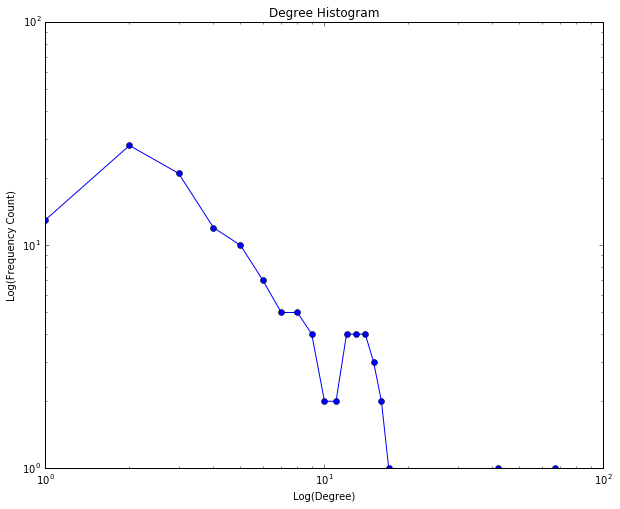

In [51]:
# Logarithmic plot of the degree distribution.
values = sorted(set(degrees.values())) 
hist = [degrees.values().count(x) for x in values]
out = plt.loglog(values, hist, marker='o')
plt.title("Degree Histogram")
plt.ylabel("Log(Frequency Count)")
plt.xlabel("Log(Degree)")

### 2.2 Node centrality
Centrality measures provide relative measures of importance in a network. There are many different centrality measures, and each measures a different type of importance. In the video content, you were introduced to the following centrality measures:

1. **Degree centrality:** Number of connections. An important node is involved in a large number of interactions. For directed graphs, the in-degree and out-degree concepts are used. The in-degree of a Node v is the number of edges with Vertex v as the terminal vertex, and the out-degree of v is the number of edges with v as the initial vertex.

2. **Closeness centrality:** Average length of the shortest paths between a specific node and all other nodes in the graph. An important node is typically close to, and can communicate quickly with, the other nodes in the network.

3. **Betweenness centrality:** Measures the extent to which a particular vertex lies on the path between all other vertices. An important node will lie on a high proportion of paths between other nodes in the network.

4. **Eigenvector centrality:** An important node is connected to important neighbors.  

The following schematic is a demonstration and comparison of the first three of the centrality metrics discussed  above. In this figure, Node X always has the highest centrality measure, although it measures different behaviors in each case.

<img src="img\social_network_analysis_centrality.png", width=1050, height=450>

NetworkX provides the functionality to evaluate these metrics for graph objects, which will be described in the next section.

#### 2.2.1 Degree centrality

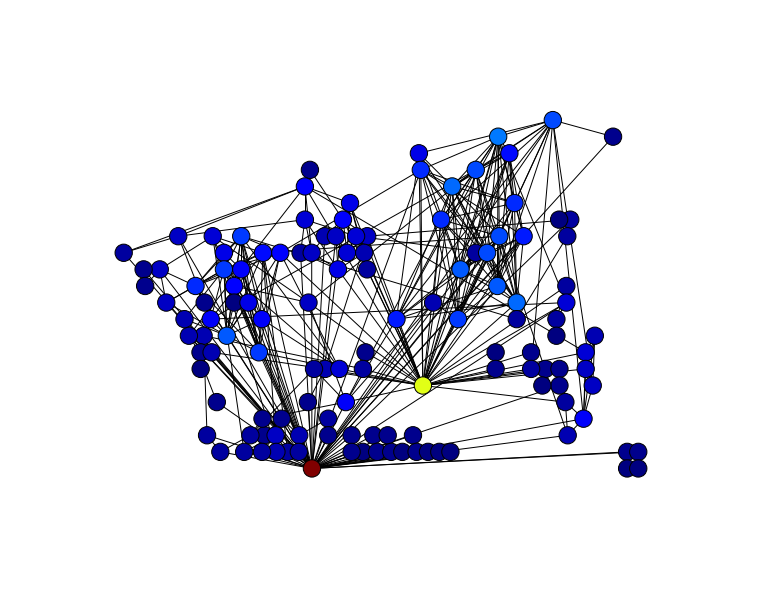

In [52]:
# Plot degree centrality.
call_degree_centrality = nx.degree_centrality(G)
colors =[call_degree_centrality[node] for node in G.nodes()]
pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos, node_color=colors, node_size=300)

The visual above uses different colors on nodes to highlight their degree centrality. Dark blue nodes have a low value, and the red-brown node indicates the highest centrality value in the network. Although it is possible to add label information on the nodes, it can become too busy and, therefore, make it difficult to read the visual. In the following example, the data is arranged according to the degree centrality measure so that the node with the highest degree centrality measure appears at the top, followed by the node with the next highest degree centrality measure, and so forth (that is, in descending order). 

In [53]:
# Arrange in descending order of centrality and return the result as a tuple, i.e. (participant_id, deg_centrality).
t_call_deg_centrality_sorted = sorted(call_degree_centrality.iteritems(), key=lambda (k,v) : (-v,k))

# Convert tuple to pandas dataframe.
df_call_deg_centrality_sorted = pd.DataFrame([[x,y] for (x,y) in t_call_deg_centrality_sorted], 
                                             columns=['participantID', 'deg.centrality'])

**Note:** 
> In NetworkX, the degree centrality values are *normalized* by dividing by the maximum possible degree in a simple graph ($n-1$), where $n$ is the number of nodes in the graph. To get integer values, when required, the computed degree centrality values are multiplied by ($n-1$).

You can print the nodes with the highest degree centrality measure using "`head()`".

In [54]:
# Top 5 participants with the highest degree centrality measure.
df_call_deg_centrality_sorted.head()

participantID  deg.centrality
0    fa10-01-04        0.523438
1    fa10-01-13        0.328125
2    sp10-01-49        0.132812
3    sp10-01-31        0.125000
4    sp10-01-41        0.125000

Here are some immediate questions to ask:
1. How many unique actors are associated with each of the five participants with the highest degree centrality measure?
2. How many total call interactions are associated with each of those five participants?

These questions are answered below. 

In [55]:
# Number of unique actors associated with each of the five participants with highest degree centrality measure.
for node in df_call_deg_centrality_sorted.head().participantID:
    print('Node: {0}, \t num_neighbors: {1}'.format(node, len(list(G.neighbors(node)))))

Node: fa10-01-04, 	 num_neighbors: 67
Node: fa10-01-13, 	 num_neighbors: 42
Node: sp10-01-49, 	 num_neighbors: 17
Node: sp10-01-31, 	 num_neighbors: 16
Node: sp10-01-41, 	 num_neighbors: 16


In [56]:
# Total call interactions are associated with each of these five participants with highest degree centrality measure.
for node in df_call_deg_centrality_sorted.head().participantID:
    outgoing_call_interactions = interactions['participantID.A']==node
    incoming_call_interactions = interactions['participantID.B']==node
    all_call_int = interactions[outgoing_call_interactions | incoming_call_interactions]
    print 'Node: {0}, \t total number of calls: {1}'.format(node, all_call_int.shape[0])

Node: fa10-01-04, 	 total number of calls: 2
Node: fa10-01-13, 	 total number of calls: 435
Node: sp10-01-49, 	 total number of calls: 3346
Node: sp10-01-31, 	 total number of calls: 394
Node: sp10-01-41, 	 total number of calls: 713


#### 2.2.2 Closeness centrality

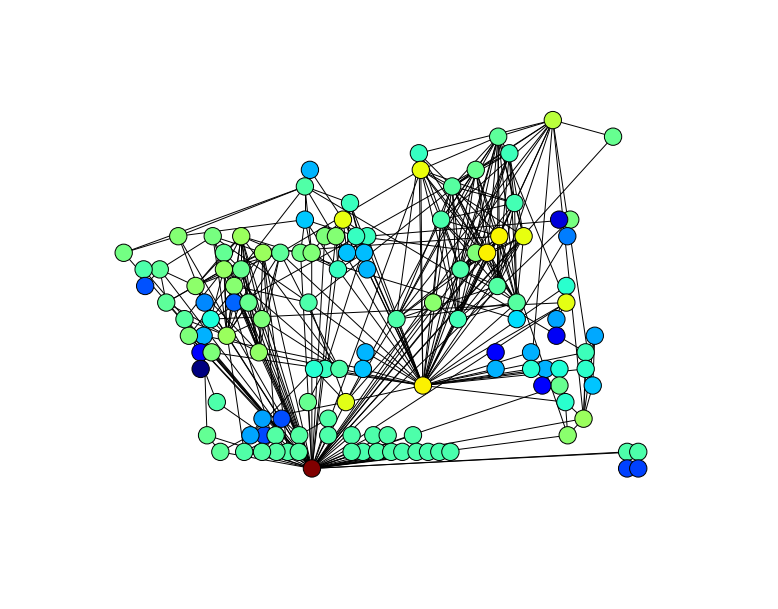

In [57]:
# Plot closeness centrality.
call_closeness_centrality = nx.closeness_centrality(G)
colors = [call_closeness_centrality[node] for node in G.nodes()]
pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos=pos,node_color=colors)

The single node with the highest closeness centrality is depicted in a red-brown color, whereas those with the lowest values are depicted in blue. To propagate information quickly in the network, one would need to involve nodes with a high closeness centrality measure.

Below, you will identify these nodes explicitly, and store the data in a separate DataFrame.

In [58]:
# Arrange participants according to closeness centrality measure, in descending order. 
# Return the result as a tuple, i.e. (participant_id, cl_centrality).
t_call_clo_centrality_sorted = sorted(call_closeness_centrality.iteritems(), key=lambda (k,v) : (-v,k))

# Convert tuple to pandas dataframe.
df_call_clo_centrality_sorted = pd.DataFrame([[x,y] for (x,y) in t_call_clo_centrality_sorted], 
                                             columns=['participantID', 'clo.centrality']) 

In [59]:
# Top 5 participants with the highest closeness centrality measure.
df_call_clo_centrality_sorted.head()

participantID  clo.centrality
0    fa10-01-04        0.624390
1    fa10-01-13        0.477612
2    sp10-01-08        0.477612
3    sp10-01-45        0.475836
4    sp10-01-48        0.468864

#### 2.2.3 Betweenness centrality

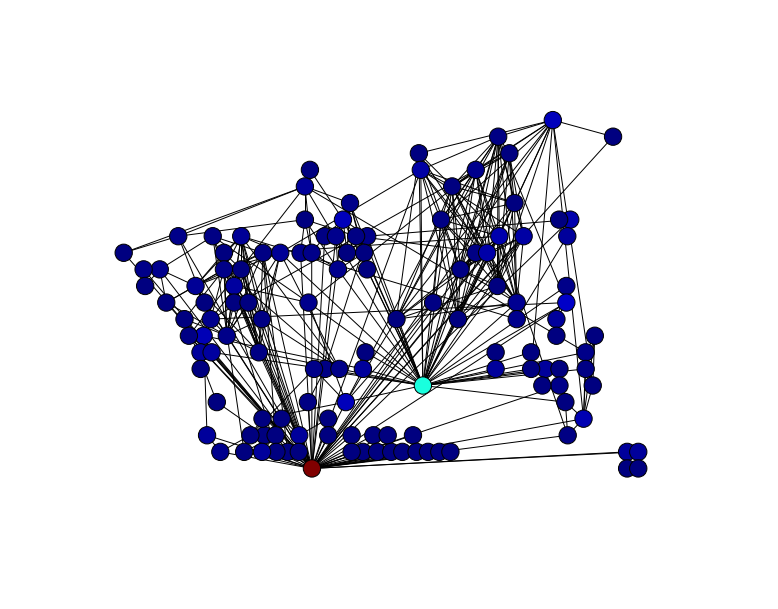

In [60]:
# Plot betweenness centrality.
call_betweenness_centrality = nx.betweenness_centrality(G)
colors =[call_betweenness_centrality[node] for node in G.nodes()]
pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos=pos, node_color=colors)

Betweenness centrality is a measure of the influence a node has over the spread of information through the network. Specifically, these nodes are strategically positioned, and dictate information flow across the network. In the visual above, two nodes (one in cyan color and the other in a red-brown color) are highlighted as the key nodes that govern information flow in the network. You can explicitly identify these nodes by re-arranging the data in order of descending betweenness centrality measure.

In [61]:
# Arrange participants according to betweenness centrality measure, in descending order. 
# Return the result as a tuple, i.e. (participant_id, btn_centrality). 
t_call_btn_centrality_sorted = sorted(call_betweenness_centrality.iteritems(), key=lambda (k,v) : (-v,k))

# Convert tuple to a Pandas DataFrame.
df_call_btn_centrality_sorted = pd.DataFrame([[x,y] for (x,y) in t_call_btn_centrality_sorted], 
                                             columns=['participantID', 'btn.centrality']) 

In [62]:
# Top 5 participants with the highest betweenness centrality measure.
df_call_btn_centrality_sorted.head()

participantID  btn.centrality
0    fa10-01-04        0.651025
1    fa10-01-13        0.248733
2    fa10-01-76        0.042644
3    fa10-01-62        0.035216
4    fa10-01-74        0.033967

#### 2.2.4 Eigenvector centrality

The eigenvector centrality measure is based on the idea that a node is important if it is linked to other important nodes. Eigenvector centrality characterizes the "global" (as opposed to "local") prominence of a vertex in a graph. [Google’s Pagerank algorithm](http://infolab.stanford.edu/~backrub/google.html) is a variation of eigenvector centrality. 

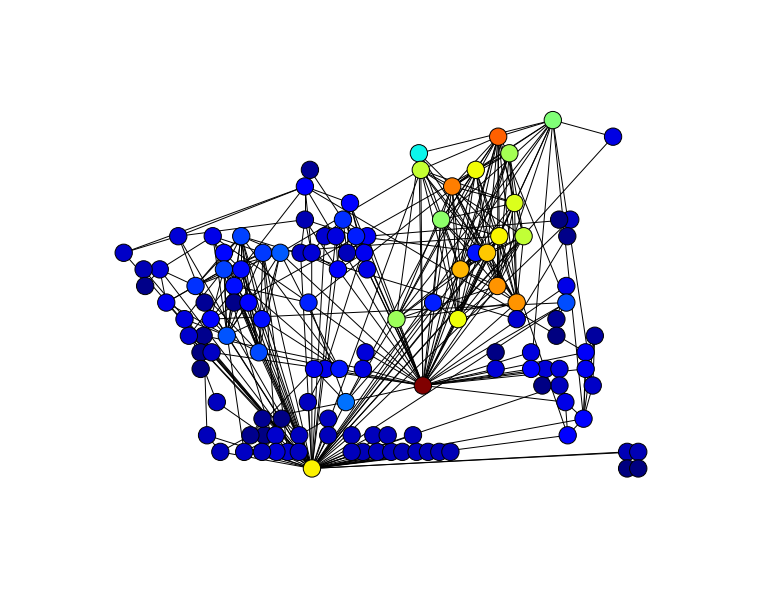

In [63]:
# Plot eigenvector centrality.
call_eigenvector_centrality = nx.eigenvector_centrality(G)
colors = [call_eigenvector_centrality[node] for node in G.nodes()]
pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos=pos, node_color=colors)

Now, identify the nodes with the highest eigenvector centrality.

In [64]:
# Arrange participants according to eigenvector centrality measure, in descending order. 
# Return the result as a tuple, i.e. (participant_id, eig_centrality).
t_call_eig_centrality_sorted = sorted(call_eigenvector_centrality.iteritems(), key=lambda (k,v) : (-v,k))

# Convert tuple to pandas dataframe.
df_call_eig_centrality_sorted = pd.DataFrame([[x,y] for (x,y) in t_call_eig_centrality_sorted], 
                                             columns=['participantID', 'eig.centrality']) 

In [65]:
# Top 5 participants with the highest eigenvector centrality measure. 
df_call_eig_centrality_sorted.head()

participantID  eig.centrality
0    fa10-01-13        0.326465
1    sp10-01-49        0.263320
2    sp10-01-41        0.253733
3    sp10-01-31        0.245286
4    sp10-01-39        0.245269

### 2.3 Comparing the connectedness measures

Based on the above examples, you should now have a sense that the centrality metrics are similar regarding how they rank important nodes, since a limited number of nodes are common across different metrics. However, they also differ because they do not always return the same nodes. In this section, analysis tools, which assist in comparing these metrics, are provided. 

Below, you are provided with a plotting function that accepts two objects containing different centrality measures as Python dicts. The metrics you found above are all in the form of Python dict objects, and can be used as is. The function plots a scatter plot of the metrics against each other, so as to compare the centrality measures.

> **Note**:

> You do not need to understand the function and its syntax. It is included for advanced students, and to make it possible to demonstrate the concepts in this section to you more easily. All you need to do is **execute the cell below**.

In [66]:
# Execute this cell to define a function that produces a scatter plot.
def centrality_scatter(dict1,dict2,path="",ylab="",xlab="",title="",line=False):
    '''
    The function accepts two dicts containing centrality measures and outputs a scatter plot
    showing the relationship between the two centrality measures
    '''
    # Create figure and drawing axis.
    fig = plt.figure(figsize=(7,7))
    #ax1 = fig.add_subplot(111)
    # Set up figure and axis.
    fig, ax1 = plt.subplots(figsize=(8,8))
    # Create items and extract centralities.
    items1 = sorted(dict1.items())
    items2 = sorted(dict2.items())
    xdata=[b for a,b in items1]
    ydata=[b for a,b in items2]
    ax1.scatter(xdata, ydata)

    if line:
        # Use NumPy to calculate the best fit.
        slope, yint = np.polyfit(xdata,ydata,1)
        xline = plt.xticks()[0]
        yline = map(lambda x: slope*x+yint,xline)
        ax1.plot(xline,yline,ls='--',color='b')
        # Set new x- and y-axis limits.
        plt.xlim((0.0,max(xdata)+(.15*max(xdata))))
        plt.ylim((0.0,max(ydata)+(.15*max(ydata))))
        # Add labels.
        ax1.set_title(title)
        ax1.set_xlabel(xlab)
        ax1.set_ylabel(ylab)

#### 2.3.1 Compare betweenness centrality and degree centrality
Use a scatter plot to visually compare the betweenness centrality and degree centrality.

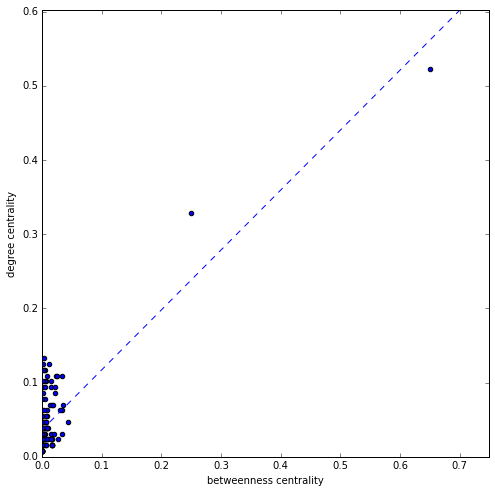

In [67]:
# Let us compare call_betweenness_centrality, call_degree_centrality.
centrality_scatter(call_betweenness_centrality, call_degree_centrality, 
                   xlab='betweenness centrality',ylab='degree centrality',line=True)

The distribution of the points in the scatter plot above is unclear due to the effect of the two nodes with very high centrality values. To better understand the distribution of other nodes, remove these nodes from the data set, and redraw the scatter plot.

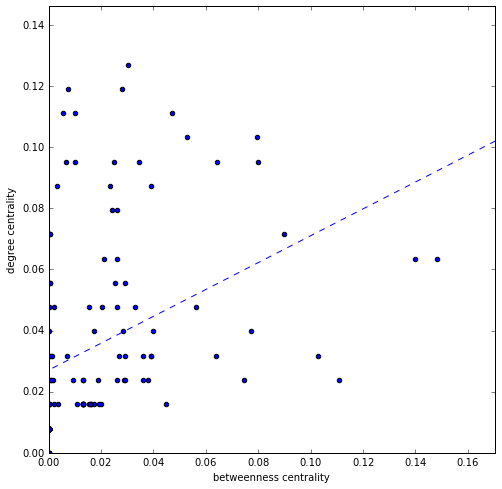

In [68]:
# Make a (deep) copy of the graph; we work on the copy.
g21 = G.copy()

# Remove the 2 nodes with the highest centrality measures as discussed above 
# Looking at the sorted values above, these are fa10-01-04 and fa10-01-13
g21.remove_node('fa10-01-04')
g21.remove_node('fa10-01-13')

# Recompute the centrality measures.
betweenness21 = nx.betweenness_centrality(g21)
centrality21 = nx.degree_centrality(g21)

# Scatter plot comparison of the recomputed measures.
centrality_scatter(betweenness21, centrality21, 
                   xlab='betweenness centrality',ylab='degree centrality',line=True)

#### 2.3.3 Merge the centrality measures into a single DataFrame
You can also use Pandas to merge all of the centrality measures that you have computed into a single DataFrame. The merge method accepts two DataFrames, and merges on a column that is common to both DataFrames. Below is a repeated call on merge that eventually outputs a single DataFrame.

In [69]:
m1 = pd.merge(df_call_btn_centrality_sorted, df_call_clo_centrality_sorted)
m2 = pd.merge(m1, df_call_deg_centrality_sorted)
df_merged  = pd.merge(m2, df_call_eig_centrality_sorted)
df_merged.head()

participantID  btn.centrality  clo.centrality  deg.centrality  \
0    fa10-01-04        0.651025        0.624390        0.523438   
1    fa10-01-13        0.248733        0.477612        0.328125   
2    fa10-01-76        0.042644        0.465455        0.046875   
3    fa10-01-62        0.035216        0.467153        0.070312   
4    fa10-01-74        0.033967        0.444444        0.109375   

   eig.centrality  
0        0.213067  
1        0.326465  
2        0.066289  
3        0.055543  
4        0.164926

The above Pandas functionality is generally quite useful when you are presented with data from different sources, and would like to combine them into a single DataFrame using a common column that is shared by both DataFrames.

Save the merged DataFrame for future use.

In [70]:
df_merged.to_csv('centrality.csv', index=False)

<br>
<div class="alert alert-info">
<b>Exercise 4 [Advanced] Start.</b>
</div>

### Instructions
> 1. Make a copy of the Graph G, and assign it to variable "g3".

> 2. Remove the **two** nodes with the highest betweenness centrality measures from "g3". 

> 3. Recompute the degree and eigenvector centrality measure for "g3", and assign the output to the variables "deg_centrality3" and "eig_centrality3", respectively.

> 4. Make a scatter plot comparison of the centrality measures, computed in the previous step, using the "``centrality_scatter``" plot function provided.

In [71]:
# Your answer here.

#### 1. Make a copy of the Graph G, and assign it to variable "g3".

In [72]:
# Making a (deep) copy of graph G; so I can work on the copy.
g3 = G.copy()

#### 2. Remove the **two** nodes with the highest betweenness centrality measures from "g3". 

In [73]:
# I will repeat the betweenness centrality sort from previous steps to establish the 2 notorious nodes.
df_call_btn_centrality_sorted.head(2)

participantID  btn.centrality
0    fa10-01-04        0.651025
1    fa10-01-13        0.248733

In [74]:
# Now I will create a new g3 graph without the offending 2 nodes
g3.remove_node('fa10-01-04')
g3.remove_node('fa10-01-13')

#### 3. Recompute the degree and eigenvector centrality measure for "g3", and assign the output to the variables "deg_centrality3" and "eig_centrality3", respectively.

In [75]:
# Recomputing the g3 centrality measures for degree and eigenvector methods
deg_centrality3 = nx.degree_centrality(g3)
eig_centrality3 = nx.eigenvector_centrality(g3)

#### 4. Make a scatter plot comparison of the centrality measures, computed in the previous step, using the "``centrality_scatter``" plot function provided.

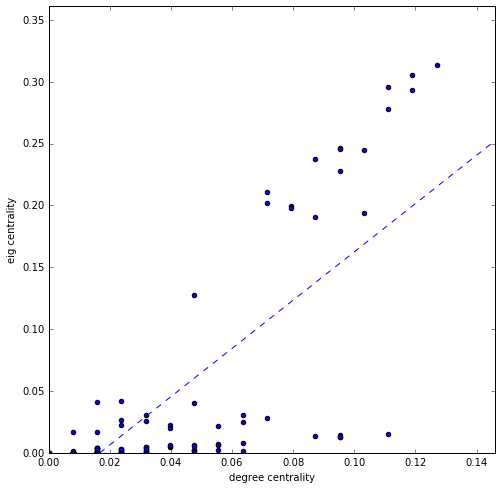

In [76]:
# Making the scatter plot to compare centrality measures for degree and eigenvector methods
centrality_scatter(deg_centrality3, eig_centrality3, 
                   xlab='degree centrality',ylab='eig centrality',line=True)

#### Observations:
>* The scatter chart doesn't look so good either, but better than the betweennes and degree measures, without log transformation
>* The eigenvector distribution looks long-tailed.
>* I will do a histogram plot to confirm this

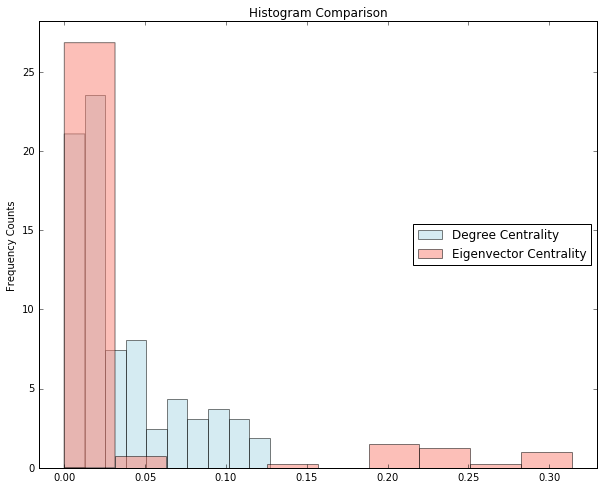

In [77]:
# plot a histogram comparison of degree vs eigenvector to see what's going on..
fig, ax = plt.subplots()

ax.hist(np.array(deg_centrality3.values()), color='lightblue', alpha=0.5, normed=True)
ax.hist(np.array(eig_centrality3.values()), color='salmon', alpha=0.5, normed=True)

ax.set(title='Histogram Comparison', ylabel='Frequency Counts')
ax.margins(0.05)
ax.set_ylim(bottom=0)

## add a legend at mid right
plt.legend(['Degree Centrality', 'Eigenvector Centrality'], loc='right')

plt.show()

#### Observations:
>* The comparison shows high eigenvector centrality for a few nodes that contrasted with low centrality for most of the nodes.
>* Degree centrality does not have as high centrality values as eingenvector.
>* Moreover, degree centrality is better spread towards higher centrality, and no so long-tailed as eigenvector distribution

<br>
<div class="alert alert-info">
<b>Exercise 4 [Advanced] End.</b>
</div>

> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

### 2.4 Average path length and network diameter

The size of a network can be calculated using two measures. The first measure of network size is simply the average distance within the network, which is equal to the average of the distances between all possible pairs of vertices. The average path length shows, on average, the number of steps it takes to get from one member of the network to another.

The second, and alternative, network size measure is the diameter, and it is defined as the shortest distance between the two most distant nodes in the network. It is representative of the linear size of a network. To compute the diameter, one looks at all of the shortest path distance values between connected edges in the network.

Both are measures of the size of the network, and can be understood as the distance between the nodes. Unlike the connectedness centrality measures, which are node-focused, average path length and diameter are global metrics on the structure of the graph. Along with degree distribution and clustering coefficient, average path length provides a robust measure of network topology.

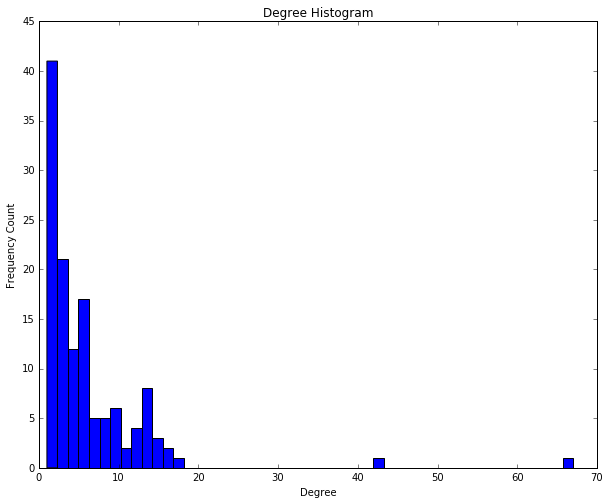

In [78]:
# Plot the degree distribution histogram.
degrees  = G.degree() # output is a dict node:degree
out = plt.hist(degrees.values(), bins=50)
plt.title("Degree Histogram")
plt.ylabel("Frequency Count")
plt.xlabel("Degree")

In [72]:
print('Diameter {}'.format(nx.diameter(G)))
print('Average path length {:0.2f}'.format(nx.average_shortest_path_length(G)))

Diameter 7
Average path length 2.71


### 2.5 Clustering coefficient

The clustering coefficient is used to measure the extent to which nodes tend to cluster together. This measure can be understood as the "friends of my friends are friends" measure. In most real-world networks, such as social networks, nodes tend to create tight-knit groups, characterized by a relatively high density of connections between nodes. This likelihood tends to be greater than the average probability of a tie randomly established between two nodes. A high clustering coefficient for a network is an indication of a small world, which is a phenomenon in which two strangers often find that they have a friend in common. Human social networks, such as on Facebook, Twitter, or LinkedIn, typically exhibit the feature that, in any cluster of friends, each friend is also connected to other friends.

Two definitions of the clustering coefficient of a graph are commonly used:
1. Global clustering
2. Average local clustering 


The **global clustering coefficient**, or  **transitivity**, was discussed in the video content, and is a measure designed to give an overall indication of the clustering in the network. It is based on  the concept of triplets of nodes. A triplet is three nodes that are connected by either two (open triplet) or three (closed triplet) undirected ties. A triangle consists of three closed triplets, one centered on each of the nodes. The global clustering coefficient is the number of closed triplets (or 3 $\times$ triangles) over the total number of triplets (both open and closed). In NetworkX, this measure can be obtained using a method called "`transitivity`", as demonstrated below.

In [79]:
print('The global clustering for our graph G is {0:.4f}'.format(nx.transitivity(G)))

The global clustering for our graph G is 0.2910


Watts and Strogatz (1998) proposed another clustering definition, which is referred to as the **local clustering coefficient**. More detail can be found in the caption of Figure 2 of their freely-available paper on [the collective dynamics of small-world networks](http://www.stevenstrogatz.com/articles/collective-dynamics-of-small-world-networks-pdf). The local clustering coefficient gives an indication of the embeddedness of single nodes or how concentrated the neighborhood of that node is. It is given by the ratio of the number of actual edges there are between neighbors to the number of potential edges there are between neighbors. The clustering coefficient of a network is then given as the average of the vertex clustering coefficients. 

The intuition behind the local clustering coefficient is illustrated below, using the following network.

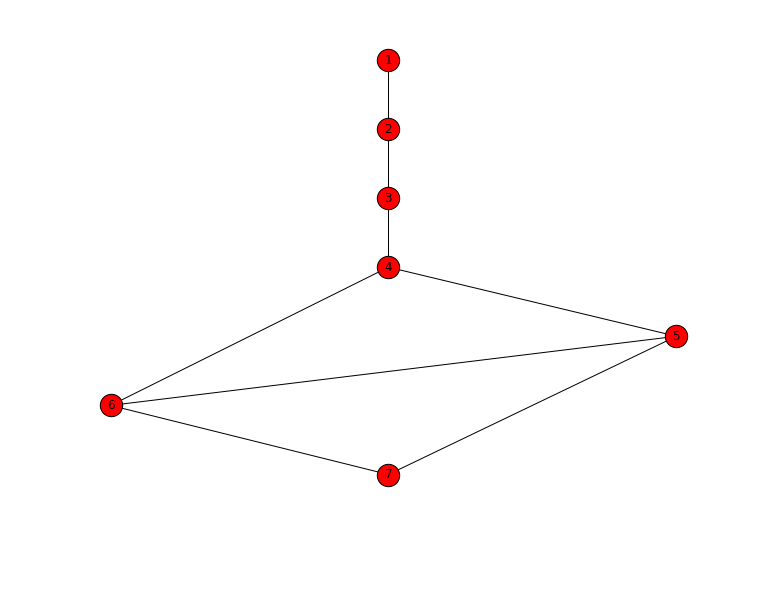

In [80]:
# Create a graph object from a provided edges list and visualize the graph. 
e = [(1,2), (2,3), (3,4), (4,5), (4,6), (5,6), (5,7), (6,7)]
g =  nx.Graph()
g.add_edges_from(e)
pos = graphviz_layout(g, prog='dot')
nx.draw(g, pos=pos, with_labels=True, node_size=500)

Choosing Node 5 as the node of interest, let's calculate its clustering coefficient (i.e., how concentrated its neighborhood is).

In [81]:
# Number of edges there are between neigbors of 5. 
actual_edges = len([(4,5), (6,7)])

# Total possible edges between neighbors of 5.
total_possible_edges = len([(4,5), (6,7), (4,7)])

# Clustering coeff of node. 
local_clustering_coef  = 1.0 * actual_edges / total_possible_edges

print(local_clustering_coef)

0.666666666667


NetworkX contains a method for calculating the clustering coefficient for all the nodes in a graph. You can specify a list of nodes as an argument when calling the method on a graph.
>**Note:** 

> The clustering coefficient is defined as zero when there are less than two neighbors in a node's neighborhood.




In [82]:
# Local clustering for node 5
print(nx.clustering(g, nodes=[5]).values()[0])

0.666666666667


Do all nodes in a network or graph have the same local clustering coefficient? Call the method without specifying the "nodes" argument.

In [83]:
nx.clustering(g)

{1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.3333333333333333,
 5: 0.6666666666666666,
 6: 0.6666666666666666,
 7: 1.0}

When applied to a single node, the clustering coefficient is a measure of how complete its neighborhood is. When applied to an entire network, it is the average clustering coefficient over all of the nodes in the network. Again, you can also compute this using NetworkX.

In [84]:
# Compute average clustering coefficient for our graph g directly.
print('(Direct) The average local clustering coefficient of the network is {:0.3f}'.format(np.mean(nx.clustering(g).values())))

# Or using NetworkX.
print('(NetworkX) The average local clustering coefficient of the network is {:0.3f}'.format(nx.average_clustering(g)))

(Direct) The average local clustering coefficient of the network is 0.381
(NetworkX) The average local clustering coefficient of the network is 0.381


With this background, you can now calculate the average clustering coefficient of the call data network from above.
> **Note**:

> On the network level, there are two versions of the clustering coefficient. The first one is the **global clustering coefficient** that you computed at the top of Section 2.5, and is discussed in the video content by Xiaowen Dong. The second one is the **average local clustering coefficient** of all the nodes in the network.

In most cases, nodes with a degree below a certain threshold are of little or no interest. For visualization purposes in particular, dense nodes are computationally costly, and do not render well when all of the nodes are included. Hence, you may want to exclude these from further analysis.

The next section investigates the effect of removing nodes with a degree of 1 on the clustering coefficient.

> **Note:**

> You do not need to understand the function and its syntax. It is included for advanced users, and to make it possible to demonstrate the concepts in this section to you more easily. All you need to do is **execute the cell below**.

In [85]:
# Define a function that trims.
def trim_degrees(g, degree=1):
    """
    Trim the graph by removing nodes with degree less than or equal to the value of the degree parameter
    Returns a copy of the graph.
    """
    g2=g.copy()
    d=nx.degree(g2)
    for n in g2.nodes():
        if d[n]<=degree: g2.remove_node(n)
    return g2

In [86]:
# Effect of removing weakly connected nodes.
G1 = trim_degrees(G, degree=1)
G3 = trim_degrees(G, degree=3)
G5 = trim_degrees(G, degree=5)

# Compare the clustering coefficient of the resulting network objects.
(round(nx.average_clustering(G),3), round(nx.average_clustering(G1),3), round(nx.average_clustering(G3),3),
round(nx.average_clustering(G5),3))

(0.43, 0.486, 0.541, 0.612)

>* Checking the reduction in number of connected components with each remove

In [87]:
# Use nx.number_connected_components
print('The number of connected nodes for G is {}; G1 is {}; G3 is {}; and G5 is {}.'.format(nx.number_connected_components(G),
                    nx.number_connected_components(G1),nx.number_connected_components(G3),nx.number_connected_components(G5)))

The number of connected nodes for G is 1; G1 is 1; G3 is 1; and G5 is 1.


<br>
<div class="alert alert-info">
<b>Exercise 5 Start.</b>
</div>

### Instructions

>In the previous example,  nodes with lower degrees were removed from the graph, and the average clustering coefficient recomputed. 

> Describe, in one sentence, the effect on the average clustering coefficient as these nodes were removed?

Your markdown answer. 

> My one sentence: 'The average clustering coefficient is improved when more and more weakly connected nodes are removed'

<br>
<div class="alert alert-info">
<b>Exercise 5 End.</b> 
</div>

> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

## 3. Small-world networks

Networks incorporating the two characteristics of a high clustering coefficient $C(p)$, and a low mean shortest path or characteristic path length $L(p)$ (but higher than a random network), i.e.,

\begin{equation}
                       C(p) >> C_{random} \hspace{0.5cm}and\hspace{0.5cm} L(p) \gtrsim  L_{random}
\end{equation}

are known as **small-world networks**. The name comes from the so-called "small world" phenomenon in which two strangers find that they have a friend in common. Human social networks typically exhibit the feature that, in any cluster of friends, each friend is also connected to other clusters. Consequently, it usually takes only a short string of acquaintances to connect any two people in a network.

<br>
<div class="alert alert-info">
<b>Exercise 6 Start.</b>
</div>

### Instructions

> Which two criteria are typically used to identify a network as a small-world network? 

Type your answer in the markdown cell below.

Your markdown answer.

>1. when the network clustering coefficient is HIGH
>2. when the mean shortest path or characteristic path length is LOW

<br>
<div class="alert alert-info">
<b>Exercise 6 End.</b>
</div>

> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

Consider the following data for three different real-world networks (Watts and Strogatz 1998), which were also mentioned in the video content. 
The first system is a collaboration graph of feature film actors.  The second is the electrical power grid of the West Coast in the United States. The third is the neural network of the nematode worm *Caenorhabditis elegans* (*C. elegans*). The graph representing film actors is a surrogate for a social network, with the advantage of being much easier to specify. The graph of the power grid is relevant to the efficiency and robustness of power networks,  and C. elegans is the sole example of a completely mapped neural network. The graphs are defined as follows: 
- Two actors are joined by an edge if they have acted in a film together. 
- For the power grid, vertices represent generators, transformers, and substations, and edges represent high-voltage transmission lines between them. 
- For C. elegans, an edge joins two neurons if they are connected by either a synapse or a gap function. 

The characteristic path lengths and clustering coefficients are reproduced for the three networks in the DataFrame, and the published comparison to random graphs (for the same number of vertices and average number of edges per vertex) is provided.

In [88]:
# Reproduce the table from the study.
tbl = pd.DataFrame(np.transpose(np.array([[3.65, 18.7, 2.65],
                                          [2.99, 12.4, 2.25],
                                          [0.79, 0.080, 0.28],
                                          [0.00027, 0.005, 0.05]])),
             index=['Film actors', 'Power grid', 'C.elegans'],
            columns = ['L.actual','L.random','C.actual','C.random'])
tbl

L.actual  L.random  C.actual  C.random
Film actors      3.65      2.99      0.79   0.00027
Power grid      18.70     12.40      0.08   0.00500
C.elegans        2.65      2.25      0.28   0.05000

Now, extend the table structure, from above, by adding two **Boolean** type columns that give the results of comparing "L.actual" to "L.random," and "C.actual" to "C.random".

In [89]:
# Compare 'L.actual' to 'L.random' to return a Boolean based on the above
tbl['L.actual gt L.random'] = tbl['L.actual'] > tbl['L.random']
tbl

L.actual  L.random  C.actual  C.random L.actual gt L.random
Film actors      3.65      2.99      0.79   0.00027                 True
Power grid      18.70     12.40      0.08   0.00500                 True
C.elegans        2.65      2.25      0.28   0.05000                 True

Finally,  the relative values "C.actual" to "C.random" can be compared.

In [90]:
tbl['C.actual gt C.random'] = tbl['C.actual'] > tbl['C.random']
tbl

L.actual  L.random  C.actual  C.random L.actual gt L.random  \
Film actors      3.65      2.99      0.79   0.00027                 True   
Power grid      18.70     12.40      0.08   0.00500                 True   
C.elegans        2.65      2.25      0.28   0.05000                 True   

            C.actual gt C.random  
Film actors                 True  
Power grid                  True  
C.elegans                   True

<br>
<div class="alert alert-info">
<b>Exercise 7 Start.</b>
</div>

### Instructions

> Based on the above computations, and the definition of a small-world network in the introduction to Section 3 of this notebook, list which of the three networks (film actors, power grid, and C. elegans) exhibit small-world phenomena.

> **Hint**:
>
>You can refer to the video content for the solution.

Your markdown answer here.

> All three networks (film actors, power grid, and C. elegans) exhibit small-world phenomena. They have short average path lengths and high clustering coefficient

<br>
<div class="alert alert-info">
<b>Exercise 7 End.</b>
</div>

> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

## 4. Saving and cleaning up 

Save your network data for use in the next notebook. NetworkX conveniently provides methods that, combined with Pandas, enable you to save the adjacency matrix.

In [91]:
# Create the adjacency matrix for call records using NetworkX and Pandas functions.
G = G.to_undirected()
nodes = list(G.nodes())
call_adjmatrix = nx.to_pandas_dataframe(G,nodelist=nodes)
call_adjmatrix.to_csv('./call.adjmatrix')

## 5. References

Zipf, George Kingsley. 1949. Human behavior and the principle of least effort: An introduction to human ecology. Reading: Addison-Wesley Press.

Blondel, Vincent D., Adeline Decuyper, and Gautier Krings. 2015. “A survey of results on mobile phone datasets analysis.” EPJ Data Science 4:1-55. doi:10.1140/epjds/s13688-015-0046-0.

Krings, Gautier. 2012. “Extraction of information from large networks.” PhD thesis, Université catholique de Louvain.

Watts, Duncan J., and Steven H. Strogatz. 1998. “Collective dynamics of "small-world" networks.” Nature 393:440-442. doi:10.1038/30918.

NetworkX. 2015. “Drawing - NetworkX 1.10 documentation.” Last modified October 26. https://networkx.github.io/documentation/networkx-1.10/reference/drawing.html. 

## 6. Submit your notebook

Please make sure that you:
- Perform a final "Save and Checkpoint";
- Download a copy of the notebook in ".ipynb" format to your local machine using "File", "Download as", and "IPython Notebook (.ipynb)"; and
- Submit a copy of this file to the Online Campus.